In [8]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [9]:
import torch
torch.cuda.is_available()

True

In [10]:
# Model
from source.custom.models.CustomBERTopic import CustomBERTopic

# Metrics
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence

# Dataset
from octis.dataset.dataset import Dataset

# Useful libraries
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch


In [11]:
datasets = [
    ('datasets/pec_471_2005/', 'PEC 471/2005'),
    ('datasets/pl_3723_2019/', 'PL 3723/2019')
]


In [12]:
sberts = [
    ('sberts/ulysses_sbert_random_double_aka_650k_nheeng/', '650K'),
    ('sberts/ulysses_sbert_map2doc_v1/', 'MAP2DOC'),
    ('sberts/ulysses_sbert_triplets/', 'Triplets'),
    ('sberts/ulysses_sbert_1mil_anama/', '1MIL'),
    ('sberts/ulysses_sbert_lr56/', 'LR56'),
    (None, 'LaBSE'),
    (None, 'all-MiniLM-L6-v2')
]


In [13]:
def load_sbert(sbert):
    """
    Load the SentenceBERT model
    :param sbert_path: path to the SentenceBERT model
    :return: SentenceBERT model
    """

    if (sbert[1] == 'all-MiniLM-L6-v2'):
        return None

    if (sbert[1] == 'LaBSE'):
        return SentenceTransformer('sentence-transformers/LaBSE', device='cpu')

    else:
        return SentenceTransformer(sbert[0], device='cpu')


In [14]:
def eval_sbert(dataset_path, sbert):
    """
    Evaluate a BERTopic model using SBERT embeddings given a dataset path and a SBERT model path.

    Parameters
    ----------
    dataset_path : path to the dataset
    sbert_path : path to the SBERT model

    Returns
    -------
    coherence_results : coherence results
    diversity_results : diversity results
    """

    dataset = Dataset()
    dataset.load_custom_dataset_from_folder(dataset_path)

    bertopic = CustomBERTopic(
        embedding_model=sbert,
        n_gram_range=(1, 3)
    )

    results = bertopic.train_model(dataset)

    coherence = Coherence(texts=dataset.get_corpus())
    diversity = TopicDiversity()

    coherence_results = coherence.score(results)
    diversity_results = diversity.score(results)

    return coherence_results, diversity_results


In [15]:
results = pd.DataFrame(
    columns=[
        'Dataset',
        'SBERT',
        'Coherence',
        'Diversity',
        'Iter']
)


In [16]:
for dataset in datasets:
    for sbert in sberts:
        for it in range(10):
            coherence, diversity = eval_sbert(dataset[0], load_sbert(sbert))
            results = results.append(
                {'Dataset': dataset[1],
                 'SBERT': sbert[1],
                 'Coherence': coherence,
                 'Diversity': diversity,
                 'Iter': it},
                ignore_index=True)


/home/matheus/anaconda3/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12040. The TBB threading layer is disabled.
  warnings.warn(problem)


In [17]:
mean_results = pd.DataFrame(results.groupby(['Dataset', 'SBERT']).mean()).reset_index()
mean_results

,Dataset,SBERT,Coherence,Diversity
0,PEC 471/2005,1MIL,-0.105497,0.733458
1,PEC 471/2005,650K,-0.047121,0.806083
2,PEC 471/2005,LR56,-0.060548,0.808750
3,PEC 471/2005,LaBSE,-0.049403,0.977500
4,PEC 471/2005,MAP2DOC,-0.139795,0.785644
5,PEC 471/2005,Triplets,-0.081848,0.788583
6,PEC 471/2005,all-MiniLM-L6-v2,-0.089311,0.660000
7,PL 3723/2019,1MIL,0.009687,0.832913
8,PL 3723/2019,650K,-0.007280,0.867756
9,PL 3723/2019,LR56,-0.058150,0.782990


In [18]:
sns.set(style="darkgrid")
sns.set_context("paper")
plt.rcParams["font.size"] = 8


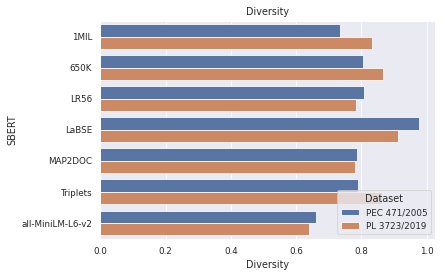

In [19]:
plt.title("Diversity")
ax = sns.barplot(x=mean_results['Diversity'], y=mean_results['SBERT'], hue=mean_results['Dataset'], orient='h')
plt.savefig('plots/diversity.svg', format='svg', dpi=1200, bbox_inches='tight')

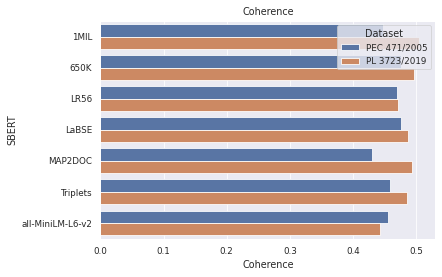

In [20]:
plt.title("Coherence")
sns.barplot(x=(mean_results['Coherence'] + 1) / 2, y=mean_results['SBERT'], hue=mean_results['Dataset'], orient='h')
plt.savefig('plots/coherence.svg', format='svg', dpi=1200, bbox_inches='tight')